In [1]:
# -*- coding: utf-8 -*-
#%% initialization
import pandas as pd # this script requires the Pandas data analysis library
import os

#%% importing PIM data
from pim_etl import pim_etl
a = pim_etl.io()
products = a['products'].fillna('')
# relationships = a['relationships'].fillna('')
# taxonomy = a['taxonomy'].fillna('')
del a

#%% importing data from Carol's report
carol_report = pd.read_excel('/Users/nathaniel.hunt/Desktop/IVEY Sales by GEO Based on CGS List of non-IVEY Authors_20180131.xlsx')
carol_report.head()

#%% importing author data
author_data = pd.read_excel('/Users/nathaniel.hunt/Desktop/Ivey_Author_Affiliation_FY15toCurrent-2.xlsx',encoding='macintosh').fillna('')
institution_columnns = [x for x in author_data.columns if 'Institution' in x]
institution_columnns
author_institutions = pd.DataFrame()
for col in institution_columnns:
    tmp = author_data[author_data[col] != '']
    author_institutions = author_institutions.append(tmp)
author_institutions = author_institutions.drop_duplicates(keep='first')
author_institution_list = []
for col in institution_columnns:
    n = col.split(' ')[-1]
    auth_col = 'Author ' + n
    tmp_dict = dict(zip(author_institutions[auth_col],author_institutions[col]))
    filtered = {a:b for a,b in tmp_dict.items() if b != ''}
    if len(filtered) > 0:
        author_institution_list.append(filtered)
author_totals = {}
rejects = []
for d in author_institution_list:
    test = set(d.keys())
    intersect = list(test.intersection(list(author_totals.keys())))
    if len(intersect) < 1:
        author_totals.update(d)
    else:
        tmp = {a:b for (a,b) in d.items() if a not in intersect}
        author_totals.update(tmp)
        rejects.append(intersect)
    
#%%    
left_outs = pd.DataFrame()
omitted = []
for col in institution_columnns:
    n = col.split(' ')[-1]
    auth_col = 'Author ' + n
    select = author_data[
        (author_data[auth_col].isin(author_totals.keys())) &
        (author_data[col] == '')
    ]
    left_outs = left_outs.append(select)
    omitted += list(select[auth_col])
left_outs = left_outs.drop_duplicates(keep='first')
omitted_dict = {}
for a in omitted:
    omitted_dict[a] = author_totals[a]
for i, j in omitted_dict.items():
    if (i,j) not in author_totals.items():
        print(i,j)


#%% create a dataframe with institution filled out for left_outs, as a way to compare
'''
def add_missing_institution(row, auth_col, author_totals):
    auth = row[auth_col]
    if auth in author_totals.keys():
        return author_totals[auth]
    else:
        return ''

left2 = left_outs.copy(deep=True)
for col in institution_columnns:
    n = col.split(' ')[-1]
    auth_col = 'Author ' + n
    left2[col] = left2.apply(add_missing_institution,axis=1,args=(auth_col,author_totals))
    
'''

#%%
non_ivey = pd.DataFrame()
for col in institution_columnns:
    n = col.split(' ')[-1]
    auth_col = 'Author ' + n
    select = author_data[
        (author_data[col] != '')
    ]
    non_ivey = non_ivey.append(select)
non_ivey = non_ivey.drop_duplicates(keep='first')
primary_non_ivey = non_ivey[non_ivey['Author Institution 1'] != '']
non_ivey_sales = carol_report[carol_report['Product Number'].isin(non_ivey['Prod Number'])]



In [2]:
#%%
carol_report['Ivey or not'] = carol_report.apply(lambda x: 'Non-Ivey' if str(x['Product Number']) in list(non_ivey['Prod Number']) else 'Ivey',axis=1)
carol_report_xref_primaryNonIvey = carol_report.copy(deep=True)
carol_report_xref_primaryNonIvey['Ivey or not'] = carol_report_xref_primaryNonIvey.apply(lambda x: 'Non-Ivey' if str(x['Product Number']) in list(primary_non_ivey['Prod Number']) else 'Ivey',axis=1)

# creates a table of yearly totals for Ivey and non-Ivey content
yearly_total_sales = carol_report.pivot_table(index='Product Number',columns='Fiscal Year (YYYY) (+)',values='Units',aggfunc='sum').fillna(0)


In [3]:
non_ivey['Author Institution 1'] = non_ivey['Author Institution 1'].str.strip()
primary_inst_counts = non_ivey.groupby('Author Institution 1',as_index=False).size().sort_values(ascending=False).reset_index().rename(columns={'Author Institution 1':'Institution',0:'Number of Products'})
primary_inst_counts = primary_inst_counts[primary_inst_counts['Institution'] != '']

def find_institution(row):
    for n in range(1,11):
        col_name = 'Author Institution ' + str(n)
        if row[col_name] != '':
            return row[col_name].strip()
            
non_ivey['Institution'] = non_ivey.apply(find_institution,axis=1)
inst_counts = non_ivey.groupby('Author Institution 1',as_index=False).size().sort_values(ascending=False).reset_index().rename(columns={'Author Institution 1':'Institution',0:'Number of Products'})
inst_counts = inst_counts[inst_counts['Institution'] != '']

# Sales by Ivey vs. Non-Ivey


### Sales with at least one non-Ivey author

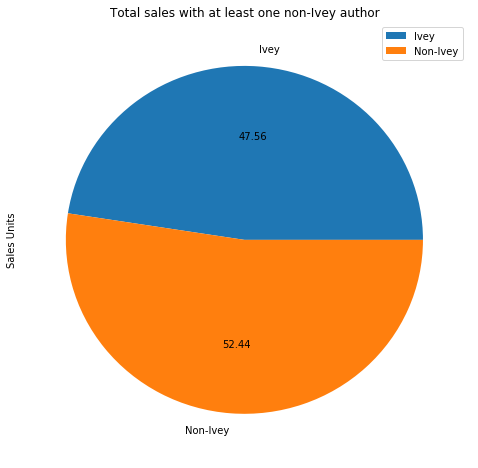

In [8]:
#%% plotting
pd.set_option('display.max_rows',500)
%matplotlib inline
from IPython.display import *
total_sales = carol_report.groupby('Ivey or not').sum()
total_sales_xref_PrimaryNonIvey = carol_report_xref_primaryNonIvey.groupby('Ivey or not').sum()
# yearly_total_sales.apply(lambda x: print(str(x.name) in non_ivey['Prod Number']),axis=1)
# yearly_total_sales['Ivey or not'] = yearly_total_sales.apply(lambda x: 'Non-Ivey' if str(x.name) in list(non_ivey['Prod Number']) else 'Ivey',axis=1)
total_sales.plot(kind='pie',autopct='%.2f',y='Units',title='Total sales with at least one non-Ivey author',label='Sales Units',figsize=(8,8)).xaxis.set_ticks_position('default')

In [9]:
display(HTML(inst_counts.to_html(index=False)))

Institution,Number of Products
Management Development Institute,36
National University of Singapore,35
"Institute of Management Technology, Ghaziabad",30
Indian Institute of Management Indore,18
American University of Beirut,13
Indian Institute of Management Raipur,13
University of Pretoria,12
SP Jain Institute of Management & Research,11
University of Calgary,11
Institute of Management Technology,10


### Sales of products with the primary author from a non-Ivey institution

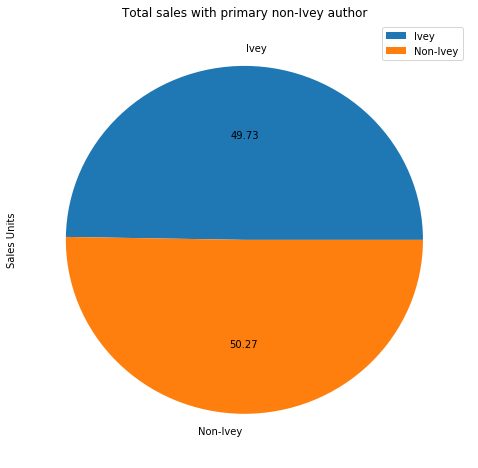

In [6]:
total_sales_xref_PrimaryNonIvey.plot(kind='pie',y='Units',autopct='%.2f',title='Total sales with primary non-Ivey author',label='Sales Units',figsize=(8,8)).xaxis.set_ticks_position('default')

In [7]:
display(HTML(primary_inst_counts.to_html(index=False)))

Institution,Number of Products
Management Development Institute,36
National University of Singapore,35
"Institute of Management Technology, Ghaziabad",30
Indian Institute of Management Indore,18
American University of Beirut,13
Indian Institute of Management Raipur,13
University of Pretoria,12
SP Jain Institute of Management & Research,11
University of Calgary,11
Institute of Management Technology,10
